In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
!unzip -uq "/content/hate speech detection.zip"

In [6]:
data =pd.read_csv("/content/labeled_data.csv")

In [7]:
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
data = data.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1)

In [9]:
data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [10]:
data.shape

(24783, 2)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


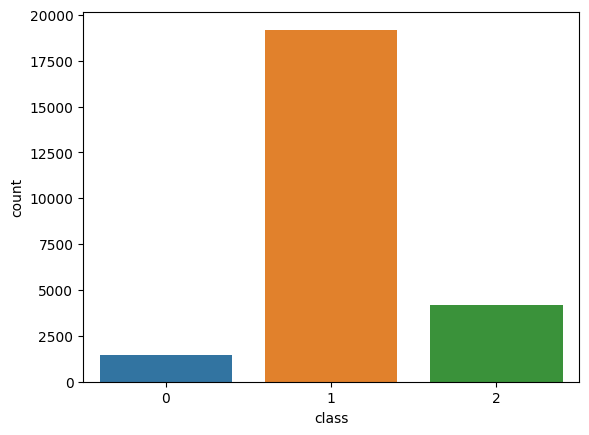

In [12]:
sns.countplot(x='class',data=data)
plt.show()

Handling imbalanced data

In [13]:
class_2 = data[data['class'] == 2]
class_1 = data[data['class'] == 1].sample(n=4000)
class_0 = data[data['class'] == 0]

df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

In [14]:
df =df.sample(frac=1).reset_index(drop=True)

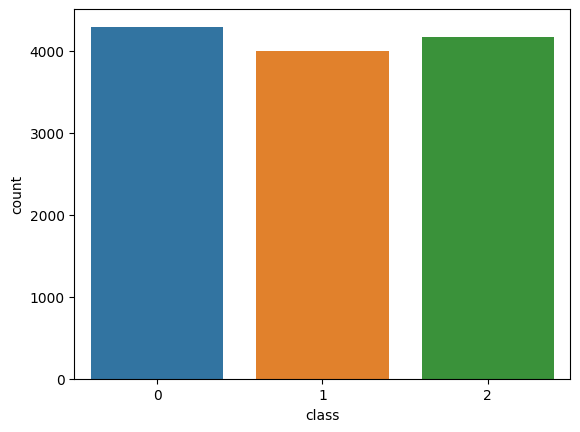

In [15]:
sns.countplot(x='class',data=df)
plt.show()

Text Preprocessing

In [16]:
from keras.layers import TextVectorization

In [17]:
X =df['tweet']
y =df['class']

In [18]:
MAX_WORD =10000
vectorizer =TextVectorization(max_tokens=MAX_WORD,output_sequence_length=100,output_mode='int')

In [19]:
vectorizer.adapt(X.values)

In [20]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'a',
 'the',
 'rt',
 'i',
 'you',
 'to',
 'bitch',
 'and',
 'is',
 'in',
 'that',
 'of',
 'my',
 'like',
 'on',
 'me',
 'for',
 'be',
 'trash',
 'this',
 'it',
 'with',
 'im',
 'your',
 'are',
 'dont',
 'bitches',
 'all',
 'just',
 'ass',
 'so',
 'up',
 'u',
 'they',
 'but',
 'if',
 'nigga',
 'hoes',
 'fuck',
 'get',
 'faggot',
 'was',
 'not',
 'at',
 'no',
 'pussy',
 'when',
 'have',
 'hoe',
 'out',
 'he',
 'these',
 'its',
 'white',
 'got',
 'lol',
 'amp',
 'can',
 'what',
 'about',
 'shit',
 'we',
 'do',
 'fucking',
 'she',
 'some',
 'one',
 'niggas',
 'how',
 'them',
 'her',
 'nigger',
 'his',
 'as',
 'youre',
 'or',
 'who',
 'aint',
 'from',
 'know',
 'go',
 'people',
 'bird',
 'love',
 'hate',
 'yankees',
 'now',
 'cant',
 'want',
 'man',
 'look',
 'charlie',
 'an',
 'yall',
 'why',
 'will',
 'good',
 'then',
 'say',
 'fag',
 'thats',
 'see',
 'think',
 'yellow',
 'only',
 'off',
 'still',
 'make',
 'too',
 'by',
 'their',
 'really',
 'yo',
 'time',
 'back',
 'wou

In [21]:
vectorized_text = vectorizer(X.values)

In [22]:
X_new =pd.DataFrame(vectorized_text)

In [23]:
y = pd.get_dummies(y)

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train ,X_test ,y_train, y_test = train_test_split(X_new,y,test_size=0.2,stratify=y,random_state=42)

In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Bidirectional,Dense,Embedding

In [27]:
model =Sequential()
model.add(Embedding(MAX_WORD+1,32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(3,activation='sigmoid'))

In [28]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320032    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                        

In [30]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",mode="min",patience =5,restore_best_weights=True)

In [31]:
history =model.fit(X_train,y_train ,validation_data =(X_test,y_test),epochs =30,callbacks=[earlystopping])

Epoch 1/30
312/312 [==============================] - 31s 68ms/step - loss: 0.4378 - accuracy: 0.6278 - val_loss: 0.3345 - val_accuracy: 0.7776
Epoch 2/30
312/312 [==============================] - 6s 20ms/step - loss: 0.1573 - accuracy: 0.9141 - val_loss: 0.1900 - val_accuracy: 0.8924
Epoch 3/30
312/312 [==============================] - 6s 20ms/step - loss: 0.0643 - accuracy: 0.9699 - val_loss: 0.1996 - val_accuracy: 0.9041
Epoch 4/30
312/312 [==============================] - 5s 16ms/step - loss: 0.0398 - accuracy: 0.9821 - val_loss: 0.2159 - val_accuracy: 0.9173
Epoch 5/30
312/312 [==============================] - 5s 15ms/step - loss: 0.0261 - accuracy: 0.9878 - val_loss: 0.2267 - val_accuracy: 0.9213
Epoch 6/30
312/312 [==============================] - 5s 17ms/step - loss: 0.0194 - accuracy: 0.9919 - val_loss: 0.2157 - val_accuracy: 0.9177
Epoch 7/30
312/312 [==============================] - 5s 15ms/step - loss: 0.0134 - accuracy: 0.9942 - val_loss: 0.2559 - val_accuracy: 0.916

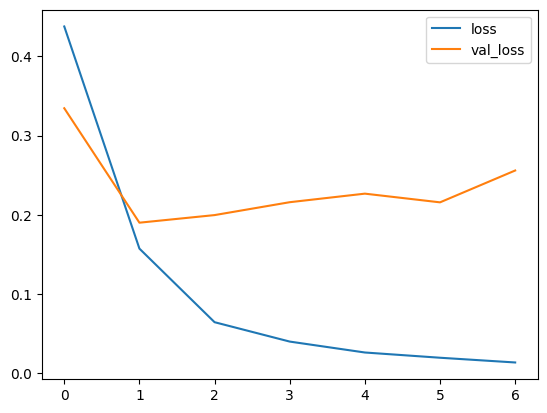

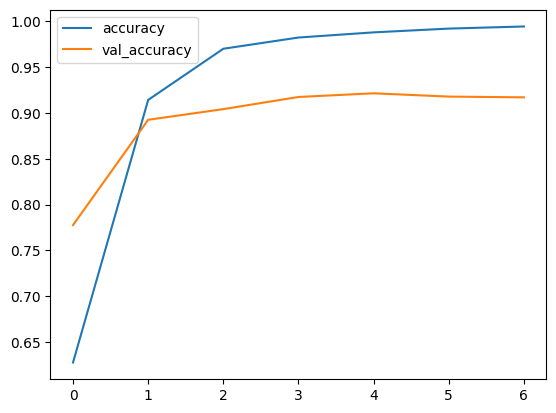

In [32]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [33]:
prediction = (model.predict(X_test)>0.5).astype(int)

78/78 [==============================] - 1s 5ms/step


In [34]:
from sklearn.metrics import confusion_matrix, classification_report

In [35]:
cm =confusion_matrix(y_test.values.argmax(axis=1),prediction.argmax(axis=1))

<Axes: >

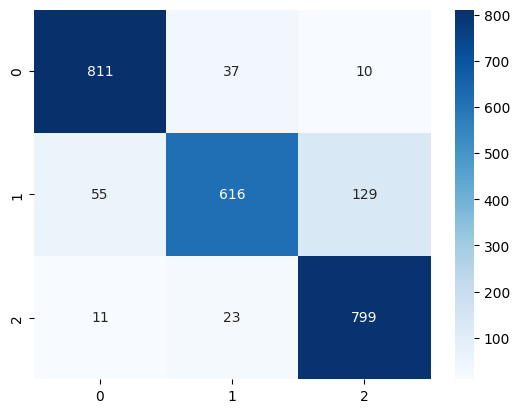

In [36]:
sns.heatmap(cm ,cmap='Blues',annot =True,fmt='0.0f')

In [37]:
print(classification_report(y_test.values.argmax(axis=1),prediction.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       858
           1       0.91      0.77      0.83       800
           2       0.85      0.96      0.90       833

    accuracy                           0.89      2491
   macro avg       0.90      0.89      0.89      2491
weighted avg       0.90      0.89      0.89      2491

